# Analysis of low E Na events

In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import glob
import os

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.snsFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 10/12/2016 at 09:36:35.


In [2]:
pmtdf = DB.DataPMT()
sipmdf = DB.DataSiPM()

In [3]:
adc_to_pes = -1.0/pmtdf["adc_to_pes"].values.reshape(12,1)

In [4]:
def events(print_mod=100):
    i = 0
    for filename in sorted(glob.glob("/Users/Gonzalo/github/IC/data/DATA/run_3100/*.h5")):
        with tb.open_file(filename) as h5f:
            for evt in h5f.root.RD.pmtcwf:
                yield i, evt
                if not i%print_mod:
                    print("event",i)
                i += 1

In [5]:
def sum_wf(wfs):
    return np.sum(wfs * adc_to_pes, axis=0)

def zs_wf(wf, thrs=0.5):
    wf = sum_wf(wf)
    t = np.arange(wf.size)/40.
    df = wfm.wf2df(t, wf)
    return wfm.wf_thr(df, thrs)

def find_peaks(wf, stride=100., min_length=100.):
    peaks = []
    t, e = wf.time_mus.values, wf.ene_pes.values
    begin = 0
    stride /= 25.
    min_length = int(min_length/25.)
    for i in range(1, t.size):
        if t[i] - t[i-1] > stride:
            if i - begin > min_length:
                peaks.append(wfm.wf2df(t[begin:i], e[begin:i]))
            begin = i
    if begin != i:
        peaks.append(wfm.wf2df(t[begin:i], e[begin:i]))
    return peaks

def plot_peaks(peaks):
    fig = plt.figure()
    fig.set_size_inches(9,7)
    for peak in peaks:
        fig.clear()
        plt.plot(peak.time_mus.values, peak.ene_pes.values)
        plt.show()
        
        raw_input("size: {} mus; E: {:.2} pes; time: {}->".format(len(peak)/40.,
                                                                  peak.ene_pes.sum(),
                                                                  peak.time_mus[np.argmax(peak.ene_pes.values)]))

def plot_pmap(pmap):
    plt.figure().set_size_inches(9,7)
    for i, peak in enumerate(pmap):
        print("Peak #{} time {} width {} mus, charge {} pes".format(i, peak.time_mus.values[np.argmax(peak.ene_pes.values)],
                                                                    len(peak)/40., peak.ene_pes.values.sum()))
        plt.plot(peak.time_mus.values, peak.ene_pes.values)

In [ ]:
evt0 = 0
for i, evt in events():
    if i>2: break
    evt0 = evt
#plt.gcf().clear()
plt.plot(sum_wf(evt0))
plt.show()
#raw_input(">")

In [6]:
pmaps = []
for i, evt in events(1000):
    pmaps.append(find_peaks(zs_wf(evt, 1.0)))

event 0
event 1000
event 2000
event 3000
event 4000
event 5000
event 6000
event 7000
event 8000
event 9000
event 10000
event 11000
event 12000
event 13000
event 14000
event 15000
event 16000
event 17000
event 18000
event 19000
event 20000
event 21000
event 22000
event 23000
event 24000
event 25000
event 26000
event 27000
event 28000


In [7]:
t, w, e, m, n = [], [], [], [], []
for pmap in pmaps:
    n.append(len(pmap))
    for peak in pmap:
        t.append(peak.time_mus[np.argmax(peak.ene_pes.values)])
        w.append(peak.time_mus.values.size)
        e.append(peak.ene_pes.values.sum())
        m.append(peak.ene_pes.values.max())
t, w, e, m = map(np.array, [t, w, e, m])
w = w/40.
r = m/e

In [32]:
skip = 0
maxn = 10
nn = 0
for i, pmap in enumerate(pmaps):
    if 4500 < max(peak.ene_pes.values.sum() for peak in pmap) < 7000:
        nn += 1
        if n > skip:
            print(i)
    if nn>= maxn + skip:
        break

92
101
168
174
181
208
307
313
370
375


Peak #0 time 399.7 width 0.125 mus, charge 14.0323703331 pes
Peak #1 time 600.675 width 6.0 mus, charge 6409.08344639 pes
Peak #2 time 969.8 width 0.125 mus, charge 12.875142135 pes
Peak #3 time 1063.75 width 0.075 mus, charge 6.48579696236 pes


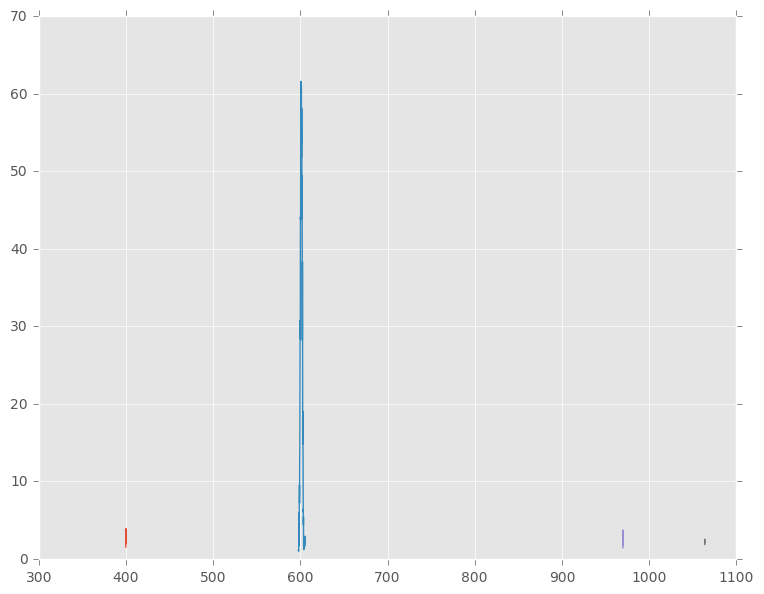

In [51]:
plot_pmap(pmaps[375])
#plt.xlim(590,610)
#plt.ylim(0,2)

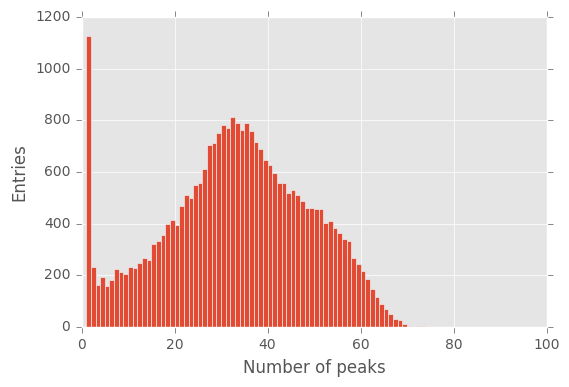

In [15]:
h = plt.hist(n, 100, range=(0,100))
plt.xlabel("Number of peaks")
plt.ylabel("Entries")

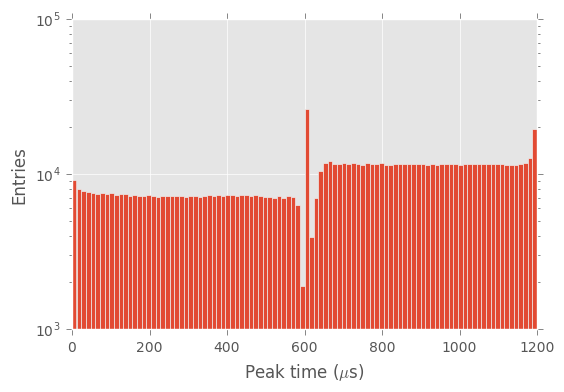

In [20]:
h = plt.hist(t, 100, range=(0,1200))
plt.yscale("log")
plt.xlabel("Peak time ($\mu$s)")
plt.ylabel("Entries")

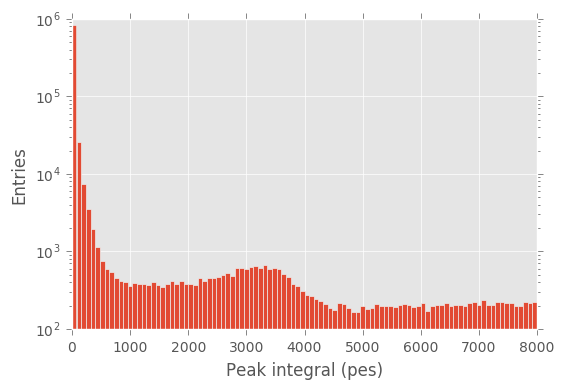

In [29]:
h = plt.hist(e, 100, range=(0,8000))
plt.yscale("log")
plt.xlabel("Peak integral (pes)")
plt.ylabel("Entries")

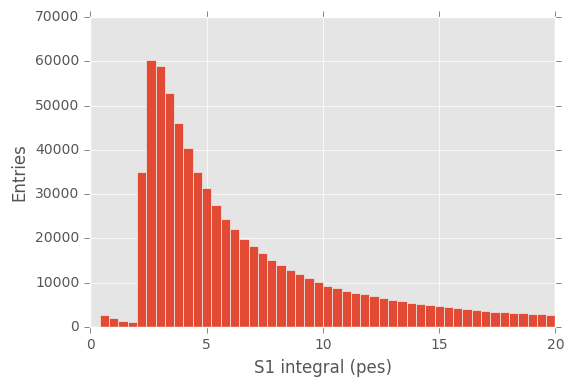

In [30]:
h = plt.hist(e, 50, range=(0,20))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")

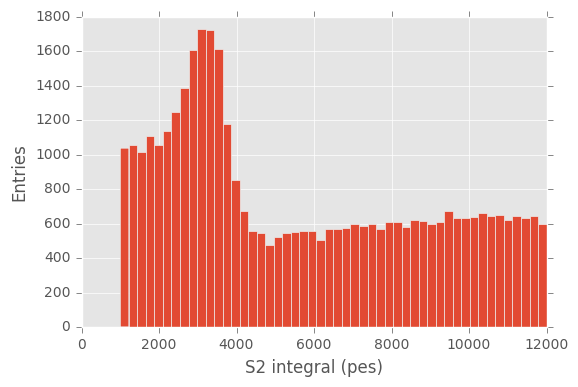

In [34]:
h = plt.hist(e, 50, range=(1000, 12000))
plt.xlabel("S2 integral (pes)")
plt.ylabel("Entries")

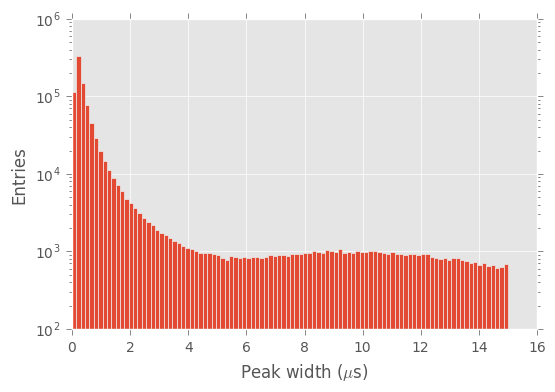

In [35]:
h = plt.hist(w, 100, range=(0, 15))
plt.yscale("log")
plt.xlabel("Peak width ($\mu$s)")
plt.ylabel("Entries")

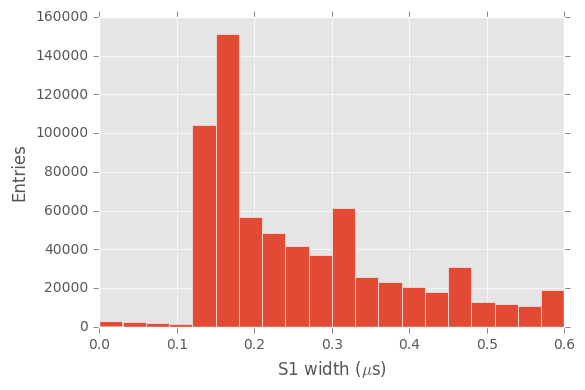

In [36]:
h = plt.hist(w, 20, range=(0, .6))
plt.xlabel("S1 width ($\mu$s)")
plt.ylabel("Entries")

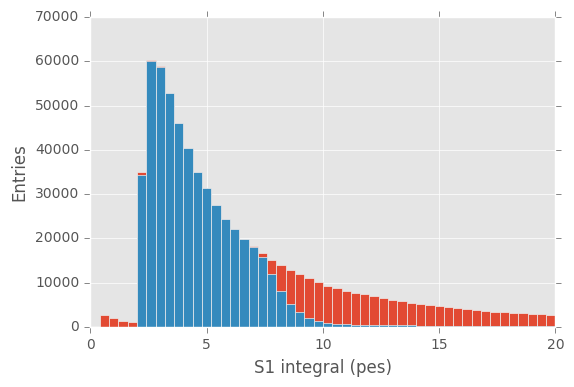

In [63]:
h = plt.hist(e, 50, range=(0,20))
h = plt.hist(e[(w>0.12) & (w<0.4)], 50, range=(0,20))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")

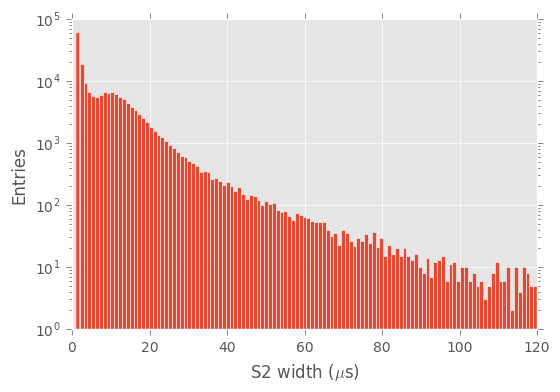

In [40]:
h = plt.hist(w, 120, range=(1, 120.))
plt.yscale("log")
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("Entries")

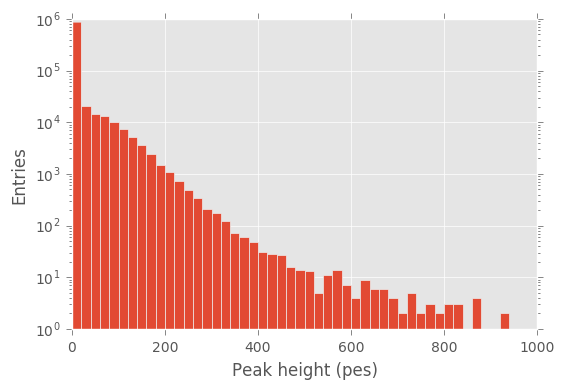

In [43]:
h = plt.hist(m, 50, range=(0, 1000.))
plt.yscale("log")
plt.xlabel("Peak height (pes)")
plt.ylabel("Entries")

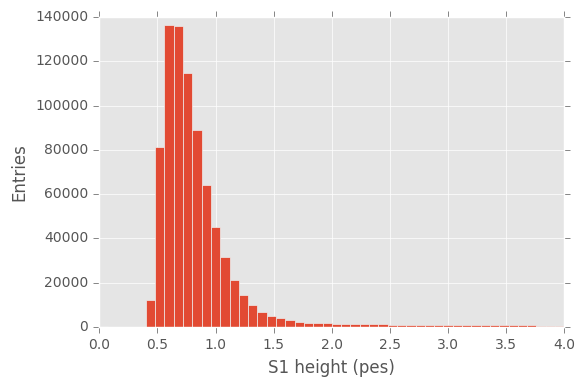

In [45]:
h = plt.hist(m, 50, range=(0, 4.))
plt.xlabel("S1 height (pes)")
plt.ylabel("Entries")

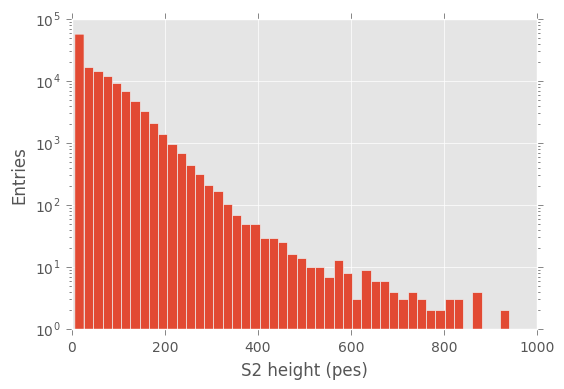

In [49]:
h = plt.hist(m, 50, range=(6, 1000.))
plt.yscale("log")
plt.xlabel("S2 height (pes)")
plt.ylabel("Entries")

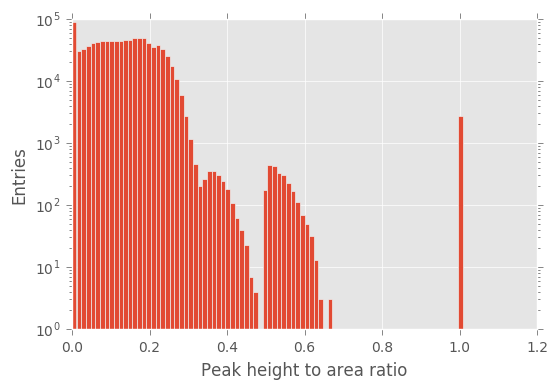

In [52]:
h = plt.hist(r, 100, range=(0, 1.2))
plt.yscale("log")
plt.xlabel("Peak height to area ratio")
plt.ylabel("Entries")

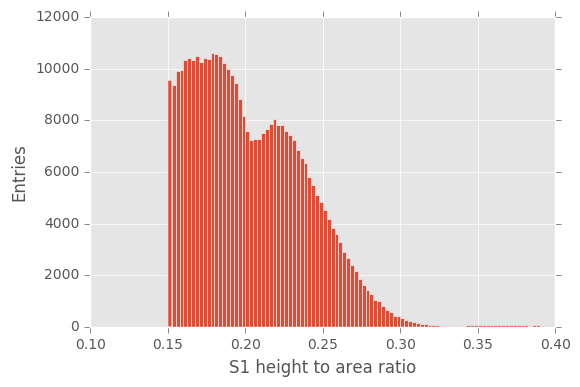

In [56]:
h = plt.hist(r, 100, range=(0.15, 0.4))
plt.xlabel("S1 height to area ratio")
plt.ylabel("Entries")

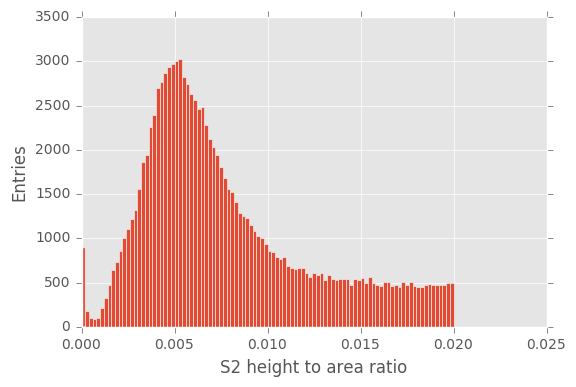

In [58]:
h = plt.hist(r, 100, range=(0., 0.02))
plt.xlabel("S2 height to area ratio")
plt.ylabel("Entries")